## Data Retrieval

Yahoo Finance API is used to get stocks data for Google over period of seven years. 

In [95]:
import yahoo_finance as yahoo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames


# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

###### Entry Parameters #######
startDate = '2010-01-01'
endDate = '2017-01-01'
ticker = 'GOOG'

#Used for re-running: stops querying the API if we already have the data
fetchData = False

#Stock Data- first step is to obtain the list of stocks, and then select a stock to run through machine learning
fileName = 'data/stocksData.csv'
###############################

# returive stock data using yahoo Finance API and return a dataFrame
def retrieveStockData():
    try:
        if fetchData:
            frames = []
            for symbol in ['GOOG']:
                print('Retriving data for ticker _' + symbol + '_ .....')
                target_data = yahoo.Share(symbol).get_historical(startDate, endDate)
                df = pd.DataFrame(target_data).sort_values(by='Date')
                df = df[['Symbol', 'Date','Open', 'Close', 'Adj_Close', 'High','Low', 'Volume']]
                frames.append(df)

            data = pd.concat(frames)    
            # save as CSV to stop blowing up their API
            data.to_csv(fileName, index_col=None, header=0, parse_dates=['Date'])
        else:
            # read the existing csv 
            data = pd.read_csv(fileName)

        data.fillna(method='ffill', inplace=True)
        data.fillna(method='bfill', inplace=True)
        #Date and Symbol columns not required
        data.drop(['Date', 'Symbol', 'Index'], axis = 1, inplace = True)
        print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
        return data 
    except:
         print "Dataset could not be loaded. Is the dataset missing?"
        

data = retrieveStockData()

display(data.head())


Populating the interactive namespace from numpy and matplotlib
Wholesale customers dataset has 1762 samples with 6 features each.


,Open,Close,Adj_Close,High,Low,Volume
0,626.951088,626.751061,313.062468,629.511067,624.241073,3927000
1,627.181073,623.991055,311.683844,627.841071,621.541045,6031900
2,625.861078,608.261023,303.826685,625.861078,606.361042,7987100
3,609.401025,594.101005,296.753749,610.001045,592.651008,12876600
4,592.000997,602.021036,300.709808,603.251034,589.110988,9483900


## Data Exploration
In this section I will explore the data through visualizations and code to understand how each feature is related to the others. I will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.


In [96]:
# Display a description of the dataset
display(data.describe())

,Open,Close,Adj_Close,High,Low,Volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,667.988556,667.732200,460.416137,673.341401,662.013391,4.051175e+06
std,159.812252,159.790218,173.765480,160.469786,159.052972,2.933264e+06
min,438.310758,436.070761,217.817563,442.280760,433.630737,7.900000e+03
25%,548.639605,547.364993,299.208801,553.582514,542.753834,1.901175e+06
50%,613.846067,614.161057,437.910342,619.111038,609.356057,3.642400e+06
75%,749.962820,749.452515,579.082539,756.218456,742.882817,5.165425e+06
max,1226.802152,1220.172036,813.109985,1228.882066,1218.602083,2.976060e+07


The first thing I notice here is that the mean values and median values differ a lot. 
That means the distribution should not be a normal distribution. In such a case, median is considered to be more reiable than mean.

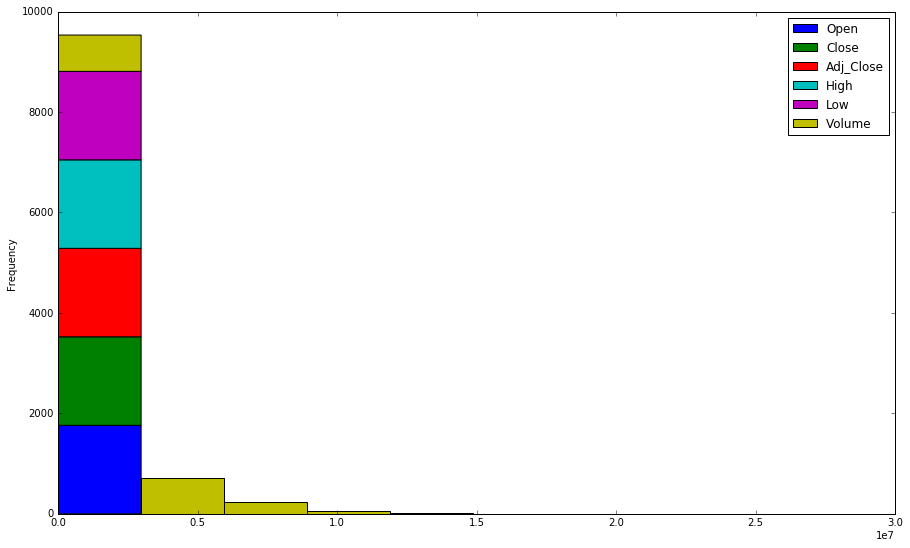

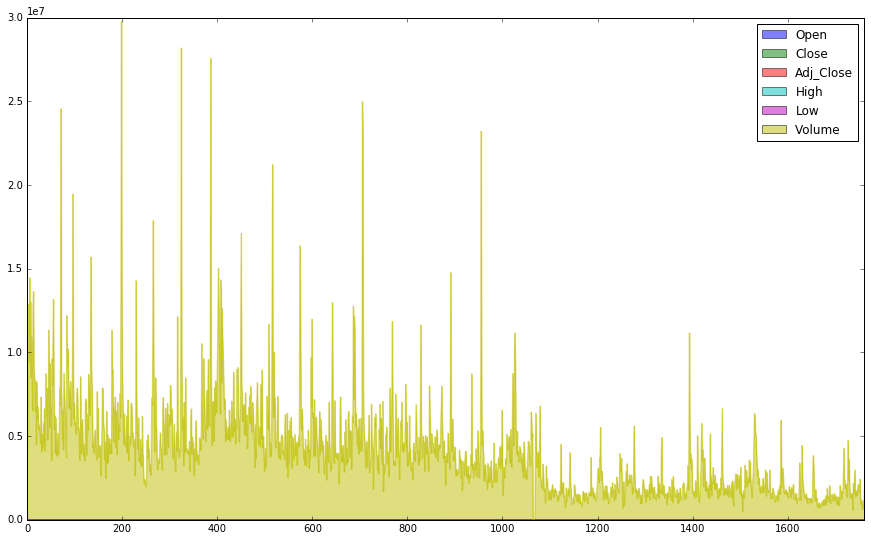

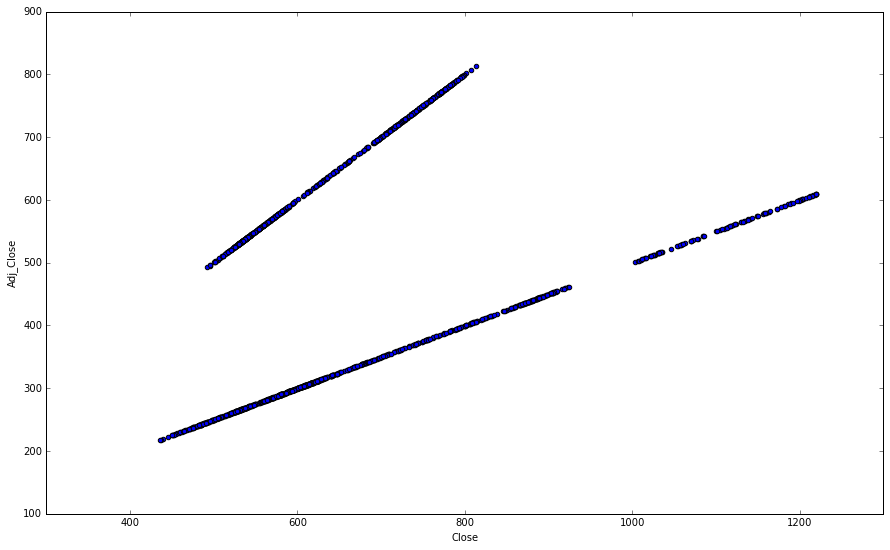

In [98]:
plt.figure();
data.plot.hist(stacked=True)
data.plot.area(stacked=False);
data.plot.scatter(x='Close', y='Adj_Close');

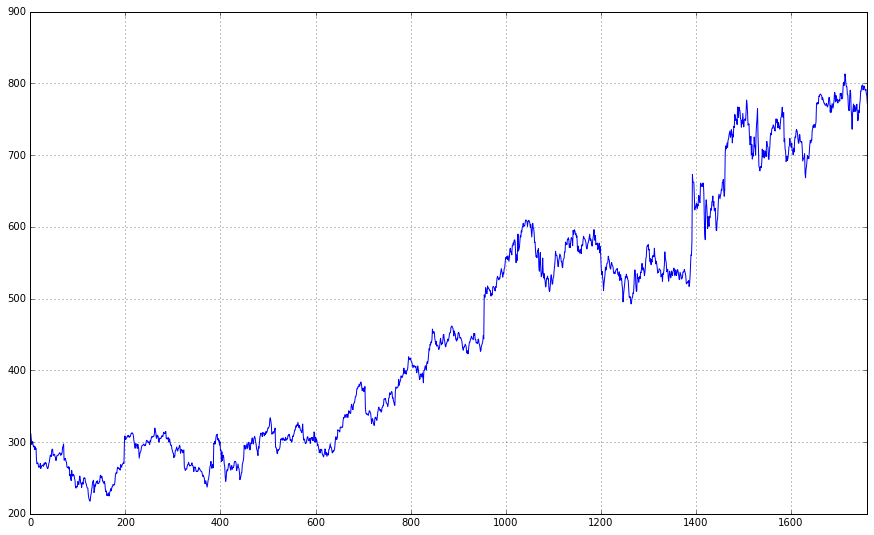

In [101]:
data["Adj_Close"].plot(grid = True)

### Implementation: Selecting Samples

To get a better understanding of stock data and how this data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add three indices to the indices list which will represent the stocks to track. 
It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [87]:
# Select three indices to sample from the dataset
indices = [50, 500, 1700]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)

print "Chosen samples of Google stock dataset:"
display(samples)

Chosen samples of Google stock dataset:


,Open,Close,Adj_Close,High,Low,Volume
0,568.301005,565.560970,282.497987,571.450956,564.250962,6668000
1,632.051074,640.251081,319.805735,644.491104,632.001082,3224800
2,776.030029,776.429993,776.429993,778.710022,772.890015,1201400


### Calculating percentile change

In [88]:
#whats of interest here is the percentage change from one day to the next
#data = data.pct_change()

#display(data.head())

## Feature Relevance 

In [89]:
for col in list(data.columns.values):    
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop(col, axis=1)

    # Split the data into training and testing sets using the given feature as the target
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[col], test_size=0.25, random_state=42)

    # Create a decision tree regressor and fit it to the training set
    from sklearn.tree import DecisionTreeRegressor
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("{} R^2 score: {:2f}".format(col ,score))

Open R^2 score: 0.998413
Close R^2 score: 0.999186
Adj_Close R^2 score: 0.785969
High R^2 score: 0.999242
Low R^2 score: 0.998872
Volume R^2 score: 0.315441


The coefficient of determination, R^2, is scored between 0 and 1, with 1 being a perfect fit. A negative R^2 implies the model fails to fit the data. 

Based on the R^2 score looks like between Open, Close and Adjacent Close prices; Close has the highest relevancy and it is best to use this to determine prediction.
Volume has the lowest score which makes it not being much useful for our predictions since the model couldn't fit trying to predict them using the others.

### Visualize Feature Distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the six stock features present in the data. 
If we found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if we believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

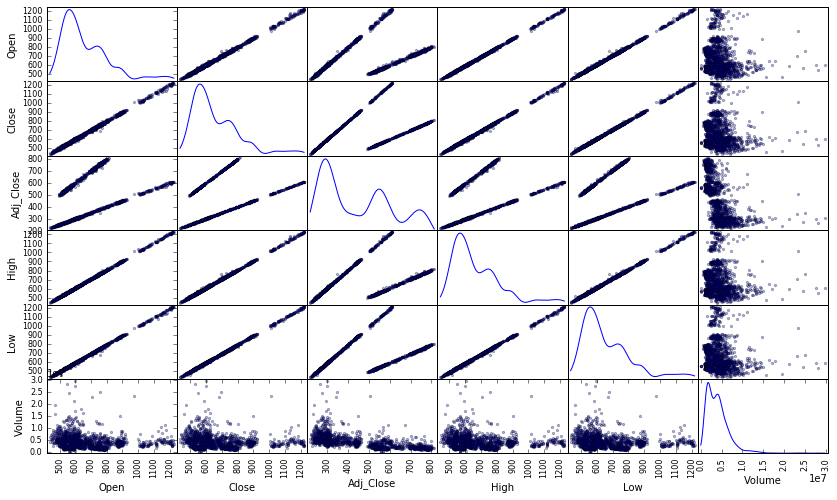

In [90]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Identifying outliers
Outliers are data points that are distinctvely separated from other data points any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.

Outliers has the biggest effect on the mean but not much effect on the median. Effecting mean can lead to effecting variance and then having largest effect on standard deviation.

In [91]:
#locate number of outliers for each column, outlier being 1.5 IQR up or down from upper or lower quartile
outliers = pd.DataFrame(index=data.index)
outliers = pd.DataFrame(np.where(
        (data > 1.5 * ((data.quantile(0.75) - data.quantile(0.25)) + data.quantile(0.75))) |
        (data < 1.5 * (data.quantile(0.25) - (data.quantile(0.75)) - data.quantile(0.25))),1, 0), 
                        columns=data.columns)

#transpose the describe so that columns can be added
res = data.describe().transpose()

display(res)

,count,mean,std,min,25%,50%,75%,max
Open,1762.0,6.679886e+02,1.598123e+02,438.310758,5.486396e+02,6.138461e+02,7.499628e+02,1.226802e+03
Close,1762.0,6.677322e+02,1.597902e+02,436.070761,5.473650e+02,6.141611e+02,7.494525e+02,1.220172e+03
Adj_Close,1762.0,4.604161e+02,1.737655e+02,217.817563,2.992088e+02,4.379103e+02,5.790825e+02,8.131100e+02
High,1762.0,6.733414e+02,1.604698e+02,442.280760,5.535825e+02,6.191110e+02,7.562185e+02,1.228882e+03
Low,1762.0,6.620134e+02,1.590530e+02,433.630737,5.427538e+02,6.093561e+02,7.428828e+02,1.218602e+03
Volume,1762.0,4.051175e+06,2.933264e+06,7900.000000,1.901175e+06,3.642400e+06,5.165425e+06,2.976060e+07


In [92]:
res['variance'] = data.var()
res['outliers'] = outliers.sum()
res['mean_x_outliers'] = (1/res['outliers'])*res['mean']


display(res['variance'])
display(res['outliers'])
display(res['mean_x_outliers'])

Open         2.553996e+04
Close        2.553291e+04
Adj_Close    3.019444e+04
High         2.575055e+04
Low          2.529785e+04
Volume       8.604037e+12
Name: variance, dtype: float64

Open          0
Close         0
Adj_Close     0
High          0
Low           0
Volume       32
Name: outliers, dtype: int64

Open                  inf
Close                 inf
Adj_Close             inf
High                  inf
Low                   inf
Volume       1.265992e+05
Name: mean_x_outliers, dtype: float64